In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
df=pd.read_csv('lean_df.csv',index_col='id')
treat_df=df.copy()

/home/auscheng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (44,53) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/auscheng/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
# treat_df.sample(10)

#### Consolidate FICO Scores

In [4]:
treat_df['fico']=(treat_df.fico_range_low+treat_df.fico_range_high)/2
treat_df=treat_df.drop(['fico_range_low','fico_range_high','last_fico_range_high','last_fico_range_low'],axis=1)

#### Remove categories with big imbalance in representation (proportion of subcategories <5% in binary categories)

In [5]:
# 2259836*0.05

In [6]:
treat_df['debt_settlement_flag'].value_counts()

N    2226422
Y      34246
Name: debt_settlement_flag, dtype: int64

In [7]:
treat_df['disbursement_method'].value_counts()

Cash         2182546
DirectPay      78122
Name: disbursement_method, dtype: int64

In [8]:
treat_df['hardship_flag'].value_counts()  

N    2259836
Y        832
Name: hardship_flag, dtype: int64

In [9]:
treat_df['initial_list_status'].value_counts()

w    1535467
f     725201
Name: initial_list_status, dtype: int64

In [10]:
treat_df['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [11]:
treat_df['verification_status'].value_counts()

Source Verified    886231
Not Verified       744806
Verified           629631
Name: verification_status, dtype: int64

In [12]:
treat_df['home_ownership'].value_counts()

MORTGAGE    1111450
RENT         894929
OWN          253057
ANY             996
OTHER           182
NONE             54
Name: home_ownership, dtype: int64

#### Removing the ones with large misrepresentation:

In [13]:
treat_df=treat_df.drop(['debt_settlement_flag','disbursement_method','hardship_flag'],axis=1)

#### Quick Initial Definition of Variable Type (Continuous, Nominal, Ordinal)

In [14]:
df_number = treat_df.select_dtypes(include = 'number')
df_object = treat_df.select_dtypes(include = 'object')
df_category = treat_df.select_dtypes(include = 'category')
df_boolean = treat_df.select_dtypes(include = 'bool')
df_datetime = treat_df.select_dtypes(include = 'datetime')
df_timedelta = treat_df.select_dtypes(include = 'timedelta')
#######################################################
nominal_var=list(df_object.columns)
ordinal_var=list(df_number.columns)
continuous_var=list(df_number.columns)
time_var=list(df_datetime.columns)

In [15]:
# df_number.head()

#### Visual Check of MultiCollinearity: Plotting Pearson

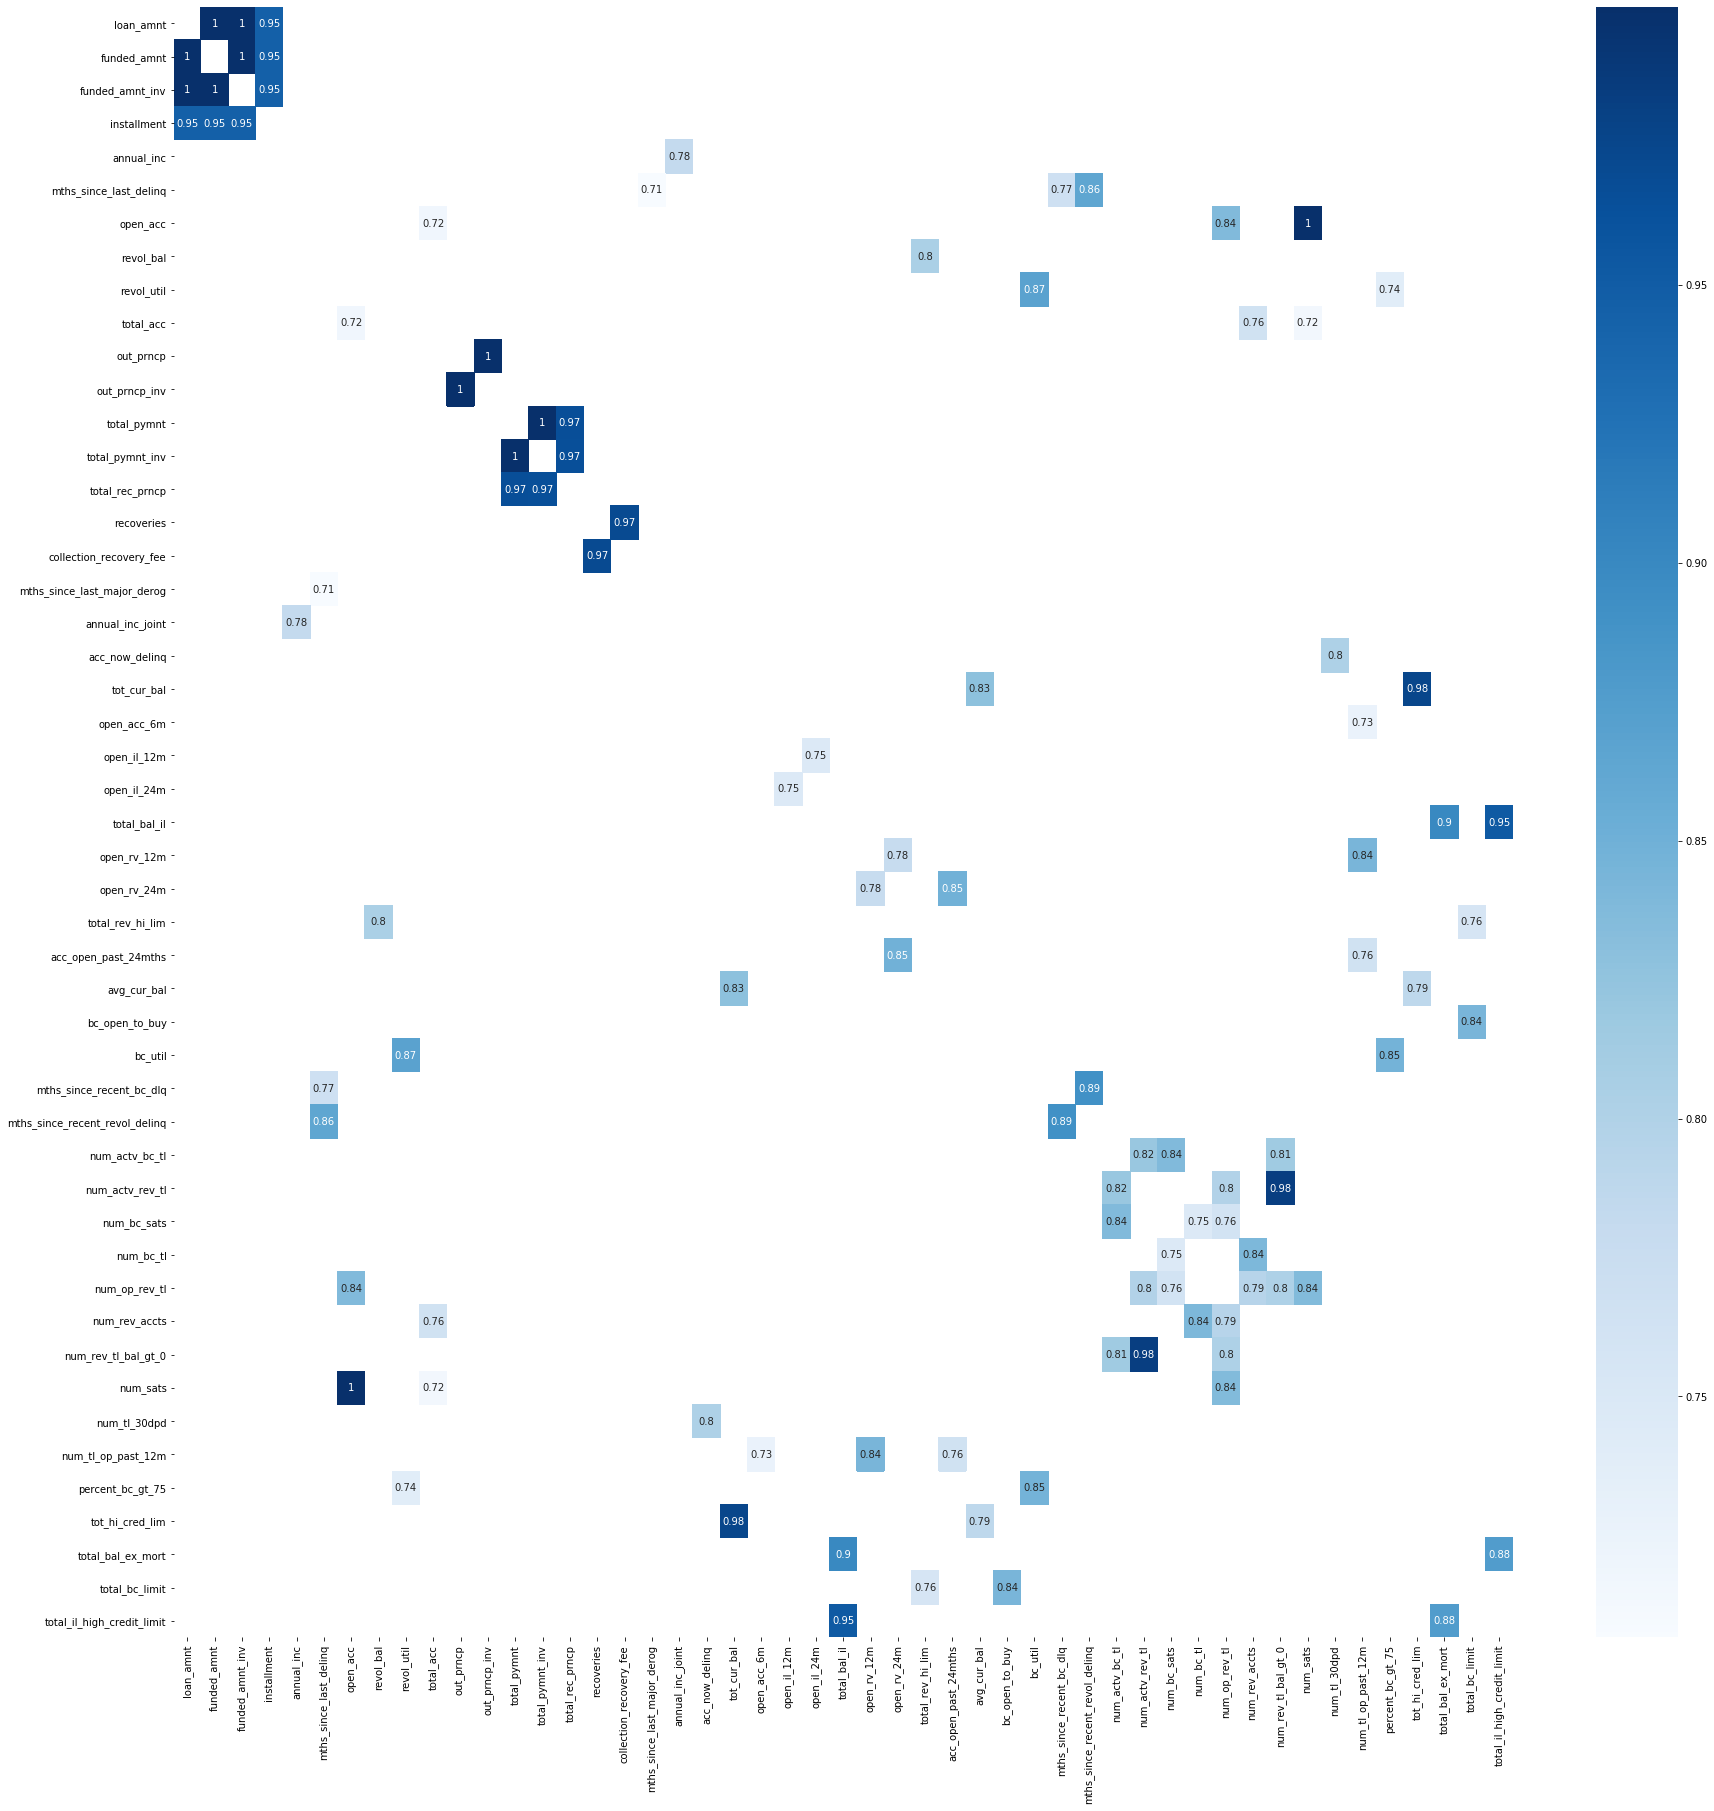

In [16]:
corr = df_number.corr(method="pearson")
big_corr=corr[abs(corr)>0.7]
big_corr.dropna(axis=0,how='all')
np.fill_diagonal(big_corr.values, np.nan)
big_corr=big_corr.dropna(axis=0,how='all')
big_corr=big_corr.dropna(axis=1,how='all')
big_corr
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(big_corr, cmap="Blues", annot = True);

#### Initial Removing anything feature that are extremely highly correlated with other features
#### First thing to take care off is that a borrower should be represented by ONE credit limit. Everything else should be expressed as fractions of the credit limit. 
#### High credit limit is better than low credit limit. high percentage of credit used is bad (low credit utilization)
#### Inquiries (bad), credit mix, payment history, credit utilization are the main factors for credit score
#### If dropping balance information (such as total_bal_il, or tot_cur_bal) is possible, then drop them first. This information will be reflected by the utilization rate such as (il_util, all_util)
#### For date related information, keep generic information such as (num_tl_op_past_12m) and drop type specific information such as (open_rv_12m). This information should be reflected by the ratio of different types of accounts (new feature from number of types of accounts)
#### drop features that say balance > 0  such as (num_rev_tl_bal_gt_0). This is because it is the same as active accounts such as (num_actv_bc_tl)

In [17]:
# total_bal_il AND total_il_high_credit_limit = 0.95            <---- drop total_bal_il 
# total_bal_ex_mort AND total_il_high_credit_limit = 0.88       <---- drop total_bal_ex_mort
# total_rev_hi_lim AND total_bc_limit = 0.76 
# bc_open_to_buy AND total_bc_limit = 0.84                      <---- drop bc_open_to_buy (covered by bc_limit)
# total_bal_il AND total_bal_ex_mort = 0.9                      <---- drop total_bal_il, total_bal_ex_mort
# total_il_high_credit_limit AND total_bal_ex_mort = 0.88       <---- drop total_bal_ex_mort
# tot_cur_bal AND tot_hi_cred_lim = 0.98                        <---- drop tot_cur_bal
# avg_cur_bal AND tot_hi_cred_lim = 0.79                        <---- drop avg_cur_bal
# bc_util AND percent_bc_gt_75 = 0.85                           <---- drop percent_bc_gt_75 (covered by bc_util)
# revol_util AND percent_bc_gt_75 = 0.74                        <---- drop percent_bc_gt_75
# open_acc_6m AND num_tl_op_past_12m = 0.73                     
# open_rv_12m AND num_tl_op_past_12m = 0.84                     <---- drop open_rv_12m
# acc_open_past_24mnths AND num_tl_op_past_12m = 0.76           
# acc_now_delinq AND num_tl_30dpd = 0.8
# open_acc AND num_sats = 1   
# total_acc AND num_sats = 0.72  
# num_op_rev_tl AND num_sats = 0.84 
# num_rev_tl_bal_gt_0 AND num_actv_bc_tl = 0.81                 <---- drop num_rev_tl_bal_gt_0                       
# num_rev_tl_bal_gt_0 AND num_actv_rev_tl =0.98                 <--- drop num_rev_tl_bal_gt_0
# num_rev_tl_bal_gt_0 AND num_op_rev_tl = 0.8                   <--- drop num_rev_tl_bal_gt_0 
# num_rev_accts AND total_acc = 0.76 
# num_rev_accts AND num_bc_tl = 0.84
# num_rev_accts AND num_op_rev_tl = 0.79

In [18]:
# Before Dropping total_bal_ex_mort and tot_cur_bal, create info on mortgage for credit mix. 
treat_df['Outstanding_mortgage_debt']= treat_df['tot_cur_bal']-df['total_bal_ex_mort']

In [19]:
# treat_df.tot_cur_bal

In [20]:
first_drop_df=treat_df.drop(['total_bal_il','total_bal_ex_mort','bc_open_to_buy','tot_cur_bal',\
               'avg_cur_bal','percent_bc_gt_75','open_rv_12m','num_rev_tl_bal_gt_0'],axis=1)

#### Creating the fractions for different types of accounts

In [21]:
first_drop_df.loc[:,['num_rev_accts','num_op_rev_tl','num_actv_rev_tl','num_bc_tl','num_actv_bc_tl','num_il_tl','mort_acc','total_acc','open_acc']].iloc[0:10,:]

,num_rev_accts,num_op_rev_tl,num_actv_rev_tl,num_bc_tl,num_actv_bc_tl,num_il_tl,mort_acc,total_acc,open_acc
id,,,,,,,,,
68407277,9.0,4.0,4.0,5.0,2.0,3.0,1.0,13.0,7.0
68355089,27.0,20.0,5.0,17.0,5.0,6.0,4.0,38.0,22.0
68341763,7.0,4.0,3.0,4.0,2.0,6.0,5.0,18.0,6.0
66310712,13.0,10.0,5.0,10.0,4.0,2.0,1.0,17.0,13.0
68476807,19.0,7.0,6.0,9.0,4.0,10.0,6.0,35.0,12.0
68426831,4.0,4.0,3.0,2.0,2.0,2.0,0.0,6.0,5.0
68476668,16.0,9.0,6.0,5.0,4.0,7.0,4.0,27.0,12.0
67275481,3.0,3.0,2.0,3.0,2.0,9.0,3.0,15.0,8.0
68466926,19.0,13.0,9.0,10.0,6.0,3.0,1.0,23.0,14.0


In [22]:
#### First we see that the accounts can be broken down into the following fractions (roughly):
#### num_rev_accts / total_acc = revol_frac
#### num_il_tl / total_acc = install_frac
#### mort_acc / total_acc = mort_frac

#### There are a few other unaccounted for types of accounts. We will use them as a metric for how active the borrower is: 
#### num_bc_tl / num_rev_accts = card_frac
#### num_actv_bc_tl / num_bc_tl = active_card_frac
#### num_actv_rev_tl / num_rev_accts =  active_revol_frac
#### open_act_il / num_il_tl = active_install_frac
#### num_op_rev_tl  /num_rev_accts =  open_revol_frac   

In [23]:
first_drop_df['revol_frac']=first_drop_df['num_rev_accts']/first_drop_df['total_acc']
first_drop_df['install_frac']=first_drop_df['num_il_tl']/first_drop_df['total_acc']
first_drop_df['mort_frac']=first_drop_df['mort_acc']/first_drop_df['total_acc']

first_drop_df['card_frac']=first_drop_df['num_bc_tl']/first_drop_df['num_rev_accts']
first_drop_df['active_card_frac']=first_drop_df['num_actv_bc_tl']/first_drop_df['num_bc_tl']
first_drop_df['active_revol_frac']=first_drop_df['num_actv_rev_tl']/first_drop_df['num_rev_accts']
first_drop_df['active_install_frac']=first_drop_df['open_act_il']/first_drop_df['num_il_tl']
first_drop_df['open_revol_frac']=first_drop_df['num_op_rev_tl']/first_drop_df['num_rev_accts']

second_drop_df=first_drop_df.drop(['num_rev_accts','num_il_tl','mort_acc','num_bc_tl','num_actv_bc_tl','num_actv_rev_tl','open_act_il','num_op_rev_tl'],axis=1)

#### Quick Definition of Variable Type (Continuous, Nominal, Ordinal) Again

In [24]:
df_number = second_drop_df.select_dtypes(include = 'number')
df_object = second_drop_df.select_dtypes(include = 'object')
df_category = second_drop_df.select_dtypes(include = 'category')
df_boolean = second_drop_df.select_dtypes(include = 'bool')
df_datetime = second_drop_df.select_dtypes(include = 'datetime')
df_timedelta = second_drop_df.select_dtypes(include = 'timedelta')
#######################################################
nominal_var=list(df_object.columns)
ordinal_var=list(df_number.columns)
continuous_var=list(df_number.columns)
time_var=list(df_datetime.columns)

In [25]:
# corr = df_number.corr(method="pearson")
# big_corr=corr[abs(corr)>0.7]
# big_corr.dropna(axis=0,how='all')
# np.fill_diagonal(big_corr.values, np.nan)
# big_corr=big_corr.dropna(axis=0,how='all')
# big_corr=big_corr.dropna(axis=1,how='all')
# big_corr
# plt.subplots(figsize=(30, 30))
# cmap = sns.diverging_palette(150, 250, as_cmap=True)
# sns.heatmap(big_corr, cmap="Blues", annot = True);

#### Continuing the Removing of feature that are extremely highly correlated with other features
#### drop total_bc_limit because revolving accounts cover bank cards
#### drop num_tl_30dpd because it is covered by acc_now_delinq. Deliquency is when the account is late by 30days
#### satisfactory accounts are open accounts so remove open accounts. And create a fraction to represent fraction of accounts that are satisfactory
####  months since last delinquency together with fractions of account types should cover the months_since_recent_revol or months_since_recent_bc_dlq

In [26]:
# total_bc_limit AND total_rev_hi_lim = 0.76           <--- drop total_bc_limit because covered by total_rev_hi_lim
# num_tl_op_past_12m AND open_acc_6m = 0.73            <---- drop open_acc_6m
# num_tl_op_past_12m AND acc_open_past_24mths = 0.76   <---- drop acc_open_past_24mths
# num_tl_30dpd AND acc_now_delinq = 0.8                <---- drop num_tl_30dpd 
# num_sats AND open_acc = 1                            <---- drop open_acc
# num_sats AND total_acc = 0.72                        <---- create fraction: num_sats/total_acc = good_acc_frac
# mnths_since_recent_revol_delinq AND mnths_since_last_delinq = 0.86   <---- drop mnths_since_recent_revol_delinq
# mnths_since_recent_revol_delinq AND mnths_since_recent_bc_dlq = 0.89 <---- drop mnths_since_recent_revol_delinq
# mnths_since_recent_bc_dlq AND mnths_since_recent_revol_delinq = 0.89 <---- drop mnths_since_recent_bc_dlq
# mnths_since_recent_bc_dlq AND mnths_since_last_delinq = 0.77         <---- drop mnths_since_recent_bc_dlq


In [27]:
second_drop_df[['num_tl_op_past_12m','acc_open_past_24mths']]

,num_tl_op_past_12m,acc_open_past_24mths
id,,
68407277,3.0,4.0
68355089,2.0,4.0
68341763,0.0,6.0
66310712,1.0,2.0
68476807,4.0,10.0
68426831,0.0,0.0
68476668,2.0,6.0
67275481,0.0,4.0
68466926,2.0,7.0


In [28]:
# print(pearsonr(second_drop_df.loc[~second_drop_df['num_tl_op_past_12m'].isnull(),'num_tl_op_past_12m'],second_drop_df.loc[~second_drop_df['num_tl_op_past_12m'].isnull(),'int_rate']))
# print(pearsonr(second_drop_df.loc[~second_drop_df['acc_open_past_24mths'].isnull(),'acc_open_past_24mths'],second_drop_df.loc[~second_drop_df['acc_open_past_24mths'].isnull(),'int_rate']))
# print(pearsonr(second_drop_df.loc[~second_drop_df['open_acc_6m'].isnull(),'open_acc_6m'],second_drop_df.loc[~second_drop_df['open_acc_6m'].isnull(),'int_rate']))

In [29]:
second_drop_df['good_acc_frac'] = second_drop_df['num_sats']/second_drop_df['total_acc']
second_drop_df.drop(['num_sats','total_bc_limit','open_acc_6m','acc_open_past_24mths',\
                     'num_tl_30dpd','open_acc','mths_since_recent_revol_delinq','mths_since_recent_bc_dlq'],axis=1,inplace=True)

In [30]:
second_drop_df.to_csv('lean_df_2.csv')